# Prepare data

## Donwload images

In [2]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

## Decompress zip file

In [3]:
from zipfile import ZipFile
import os
file_name='./chest-xray-pneumonia.zip'
files_local_location='./images'
chest_xray_dir = f"{files_local_location}/chest_xray"

if not os.path.exists(chest_xray_dir):
    with ZipFile(file_name,'r') as zip:
        zip.extractall(path=files_local_location)
        print('The file has been decompressed')

## Delete repeated and unused folders

In [4]:
import shutil
from tqdm import tqdm

paths_to_delete = [ f'{chest_xray_dir}/__MACOSX/',
                    f'{chest_xray_dir}/chest_xray/']

for folder_path in tqdm(paths_to_delete):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"'{folder_path}' has been deleted deleted")
    else:
        print(f"'{folder_path}' doesn't exists")

100%|██████████| 2/2 [00:00<00:00, 2002.05it/s]

'./images/chest_xray/__MACOSX/' doesn't exists
'./images/chest_xray/chest_xray/' doesn't exists


# Setting the initial folder directories location

In [5]:
train_directory = f'{chest_xray_dir}/train'
test_directory = f'{chest_xray_dir}/test'
validation_directory = f'{chest_xray_dir}/val'

## Preparing some data

In [6]:
from config.ClassificationNames import ClassificationNames

classification_names = list(map(lambda item: item.name, ClassificationNames.to_array()))

In [ ]:
import glob

pneumonia_train_images = glob.glob(f"{train_directory}/PNEUMONIA/*")
normal_train_images = glob.glob(f"{train_directory}/NORMAL/*")
pneumonia_test_images = glob.glob(f"{test_directory}/PNEUMONIA/*")
normal_test_images = glob.glob(f"{test_directory}/NORMAL/*")
pneumonia_validation_images = glob.glob(f"{validation_directory}/PNEUMONIA/*")
normal_validation_images = glob.glob(f"{validation_directory}/NORMAL/*")

In [7]:
GLOBAL_EPOCHS = 30

# Hands on

In [8]:
from datetime import datetime

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten,
                                     GlobalAveragePooling2D, MaxPooling2D,
                                     RandomContrast, RandomRotation,
                                     RandomZoom, ReLU, Rescaling, Resizing)
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory

from config.ColorMode import ColorMode

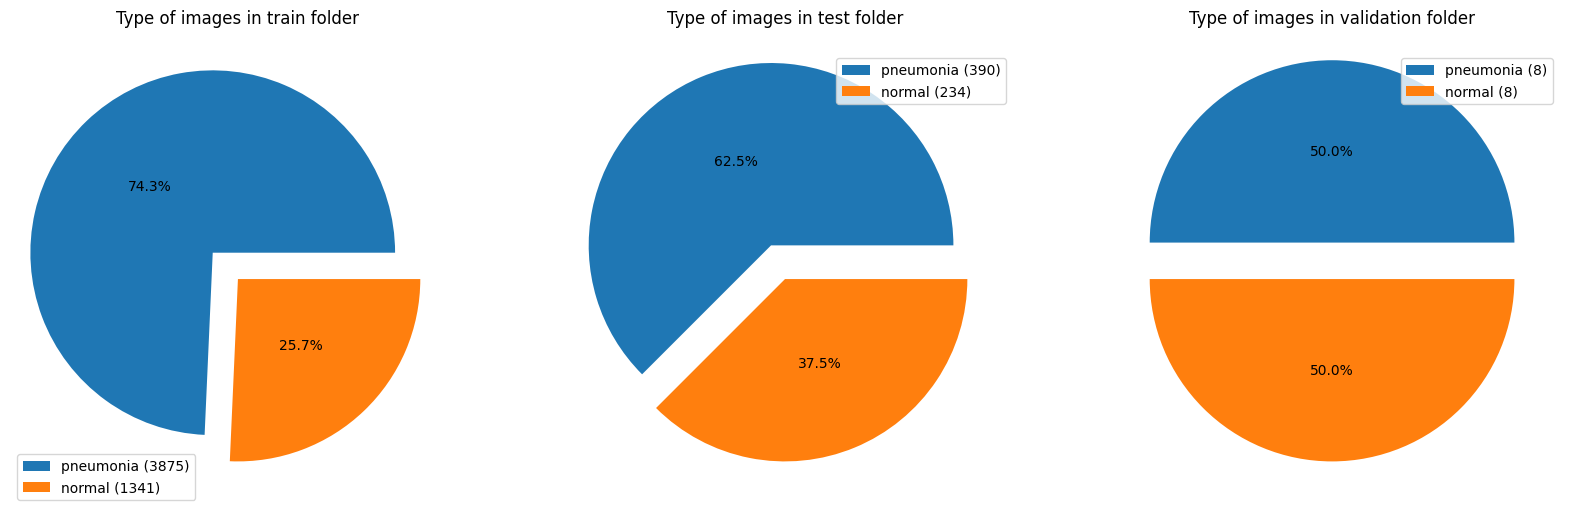

In [11]:
fig, (first_ax, middle_ax, last_ax) = plt.subplots(1, 3)

fig.set_size_inches(20,15)
first_ax.pie(x=np.array([len(pneumonia_train_images), len(normal_train_images)]),
                autopct="%.1f%%",
                explode=[0.2,0],
                pctdistance=0.5)
first_ax.set_title("Type of images in train folder", pad=20)
first_ax.legend([f"pneumonia ({len(pneumonia_train_images)})", f"normal ({len(normal_train_images)})"])

middle_ax.pie(x=np.array([len(pneumonia_test_images), len(normal_test_images)]),
                autopct="%.1f%%",
                explode=[0.2,0],
                pctdistance=0.5)
middle_ax.set_title("Type of images in test folder", pad=20)
middle_ax.legend([f"pneumonia ({len(pneumonia_test_images)})", f"normal ({len(normal_test_images)})"])

last_ax.pie(x=np.array([len(pneumonia_validation_images), len(normal_validation_images)]),
            autopct="%.1f%%",
            explode=[0.2,0],
            pctdistance=0.5)
last_ax.set_title("Type of images in validation folder", pad=20)
last_ax.legend([f"pneumonia ({len(pneumonia_validation_images)})", f"normal ({len(normal_validation_images)})"])

plt.show()


In [12]:
image_size = (220, 220)
batch_size = 16
input_shape = (220, 220, 3) # color_mode = rgb
# input_shape = (220, 220, 1) # color_mode = greyscale
color_mode = ColorMode.RGB.name.lower()
train_dataset = image_dataset_from_directory(directory=train_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=True
                                                )
validation_dataset = image_dataset_from_directory(directory=validation_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=True
                                                )
test_dataset = image_dataset_from_directory(directory=test_directory,
                                                labels='inferred',
                                                label_mode='binary',
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                image_size=image_size,
                                                shuffle=False
                                                )


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


## Feature Extraction

In [82]:
# data_augmentation = Sequential(name="data_augmentation",
#                                 layers=[
#                                         Rescaling(1./255),
#                                         RandomRotation(factor=0.4, seed=0),
#                                         RandomZoom(height_factor=.1,
#                                                         width_factor=.1,
#                                                         fill_mode='nearest',
#                                                         seed=0)
#                                         ]
#                                 )

def get_model():

    inputs = tf.keras.layers.Input(shape=input_shape)

    # Block One
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)

    # Block Two
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Block Three
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    # Head
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    #Final Layer (Output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model_name = f'model_{datetime.utcnow().strftime("%m%d%y_%H%M%S")}'

    return tf.keras.Model(inputs=[inputs], outputs=output, name=model_name)

Model: "model_110222_214343"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 220, 220, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 218, 218, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 218, 218, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 218, 218, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 109, 109, 1

In [ ]:

tf.keras.backend.clear_session()

model = get_model()
model.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(learning_rate=1e-5),
                metrics = [BinaryAccuracy(), Accuracy()])

model.summary()

In [90]:
# steps_per_epoch = len(train_dataset)/batch_size
steps_per_epoch = len(train_dataset)
# validation_steps = len(test_dataset)/batch_size
validation_steps = len(test_dataset)

history = model.fit(train_dataset,
                    steps_per_epoch = steps_per_epoch,
                    epochs=GLOBAL_EPOCHS,
                    validation_data=test_dataset,
                    validation_steps=validation_steps,
                    callbacks=[tf.keras.callbacks.TensorBoard('model_logs')])

Epoch 1/30
326/326 [==============================] - 9s 27ms/step - loss: 0.1639 - binary_accuracy: 0.9327 - accuracy: 0.0000e+00 - val_loss: 1.7562 - val_binary_accuracy: 0.1875 - val_accuracy: 0.0000e+00
Epoch 2/30
326/326 [==============================] - 9s 27ms/step - loss: 0.1328 - binary_accuracy: 0.9482 - accuracy: 3.8344e-04 - val_loss: 1.4537 - val_binary_accuracy: 0.4375 - val_accuracy: 0.0000e+00
Epoch 3/30
326/326 [==============================] - 9s 27ms/step - loss: 0.1114 - binary_accuracy: 0.9584 - accuracy: 5.7515e-04 - val_loss: 1.7816 - val_binary_accuracy: 0.2083 - val_accuracy: 0.0000e+00
Epoch 4/30
326/326 [==============================] - 9s 26ms/step - loss: 0.1016 - binary_accuracy: 0.9611 - accuracy: 0.0012 - val_loss: 1.7365 - val_binary_accuracy: 0.2708 - val_accuracy: 0.0000e+00
Epoch 5/30
326/326 [==============================] - 9s 27ms/step - loss: 0.0923 - binary_accuracy: 0.9672 - accuracy: 0.0017 - val_loss: 1.4777 - val_binary_accuracy: 0.3750 

In [91]:
model.save(f'{model.name}.h5')

In [92]:
history.history

{'loss': [0.16388043761253357,
  0.1327589601278305,
  0.1113608106970787,
  0.10159234702587128,
  0.09225460141897202,
  0.0872068777680397,
  0.08456490933895111,
  0.07426105439662933,
  0.07257899641990662,
  0.0712481290102005,
  0.06279139965772629,
  0.06008365377783775,
  0.05690012872219086,
  0.05322905257344246,
  0.05547642707824707,
  0.05252717062830925,
  0.05308791249990463,
  0.04421691596508026,
  0.04253556951880455,
  0.046636298298835754,
  0.041468024253845215,
  0.04120056703686714,
  0.039315566420555115,
  0.03854799270629883,
  0.03228210657835007,
  0.03451963886618614,
  0.032121092081069946,
  0.029526101425290108,
  0.029985832050442696,
  0.0321158729493618],
 'binary_accuracy': [0.9327070713043213,
  0.9482361674308777,
  0.9583972096443176,
  0.9610812664031982,
  0.9672162532806396,
  0.9679831266403198,
  0.9672162532806396,
  0.9706671833992004,
  0.9708588719367981,
  0.9712423086166382,
  0.974693238735199,
  0.9777607321739197,
  0.97699385881423

In [93]:
accuracy = history.history['accuracy']
binary_accuracy = history.history['binary_accuracy']
val_binary_accuracy  = history.history['val_binary_accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

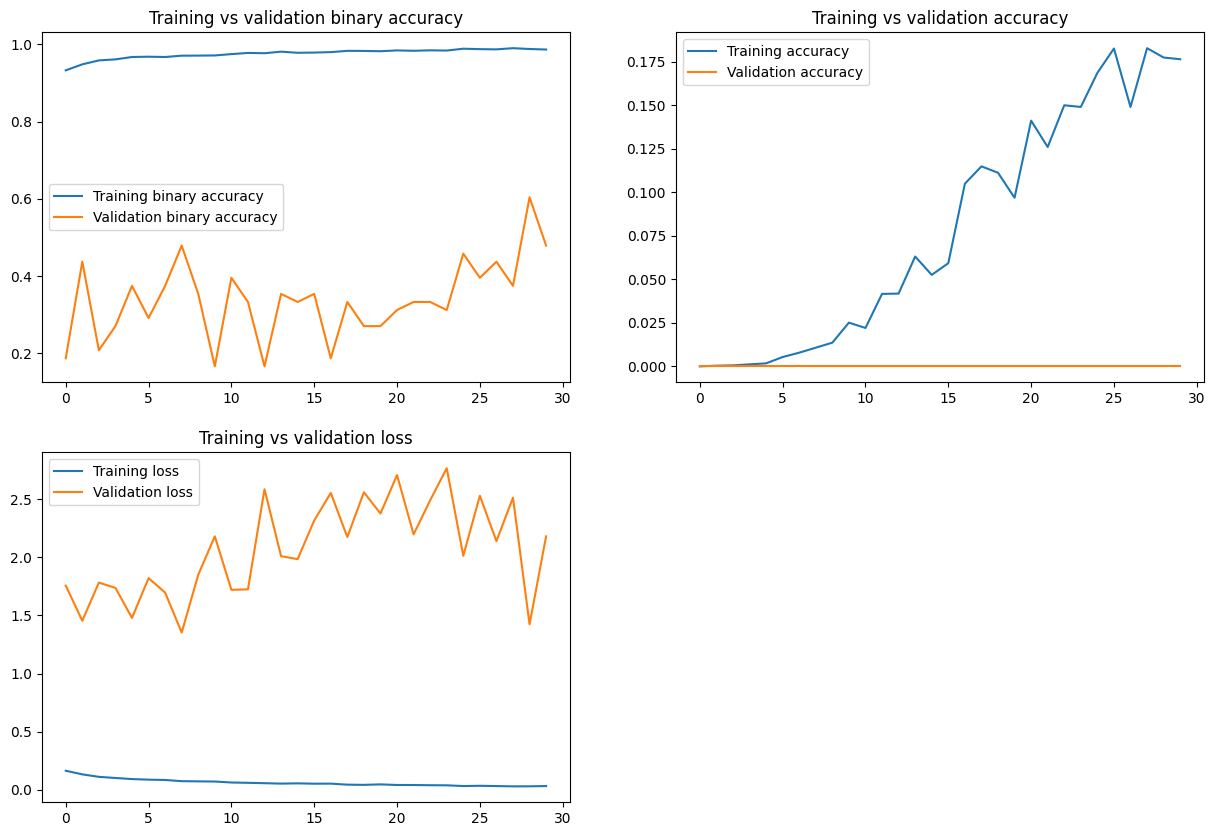

In [94]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(binary_accuracy, label = "Training binary accuracy")
plt.plot(val_binary_accuracy, label="Validation binary accuracy")
plt.legend()
plt.title("Training vs validation binary accuracy")

plt.subplot(2, 2, 2)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2, 2, 3)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()


In [95]:
pred = model.predict(validation_dataset)
pred

1/1 [==============================] - 0s 121ms/step


array([[0.80802435],
       [0.9999945 ],
       [0.31829047],
       [0.99947864],
       [0.95896417],
       [0.12501399],
       [0.99995863],
       [0.106841  ],
       [0.9999331 ],
       [0.82126826],
       [0.9999677 ],
       [0.99999964],
       [0.00493395],
       [0.9999869 ],
       [0.8044469 ],
       [0.76948327]], dtype=float32)

In [96]:
predicted_probs = np.empty([1,1])
y_true =  np.empty([1,1])
for images, labels in tqdm(validation_dataset):
    predicted_probs = np.concatenate((predicted_probs, model(images)))
    y_true = np.concatenate([y_true, labels.numpy()])
predicted_probs = np.delete(predicted_probs, [0])
y_true = np.delete(y_true, [0])
y_pred = [1 * (x>=0.5) for x in predicted_probs]


100%|██████████| 1/1 [00:00<00:00, 13.72it/s]


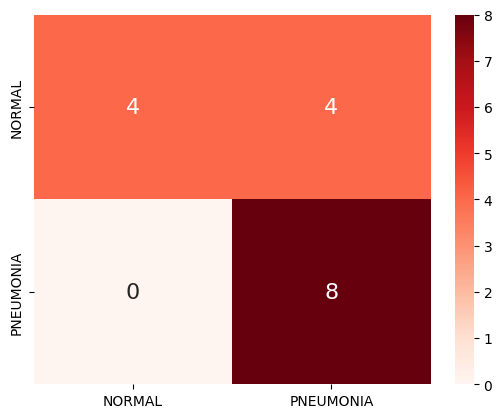

In [97]:
cm = confusion_matrix(y_true, y_pred)
hm = sn.heatmap(cm, annot=True, cmap="Reds", annot_kws={"size": 16}, fmt='d', xticklabels=classification_names, yticklabels=classification_names)

In [98]:
print(classification_report(y_true, y_pred, target_names=classification_names))

              precision    recall  f1-score   support

      NORMAL       1.00      0.50      0.67         8
   PNEUMONIA       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16

